In this Notebook I'll try to give a visual hint of how different models for machine learning work when applied to the problem of predicting the color of a pixel in an image given its coordinates. The model is trained on a set of other pixel coordinates and colors for the same image.

This notebook requires Python 3.6 and the dependencies in `requirements.txt`. 

In [1]:
import itertools
from datetime import datetime

from matplotlib import pyplot
import numpy as np
from scipy import ndimage

def log(message, *args):
    if len(args) == 0:
        print(f'{datetime.now().isoformat()} {message}')
    else:
        print(f'{datetime.now().isoformat()} {message}', args)



In [2]:
# load and convert to uint8
photo = pyplot.imread('../data/Grant_Wood_-_American_Gothic_-_Google_Art_Project.jpg').astype(np.uint8)


Now photo is a numpy array of shape (X,Y,3), where 3 is the number of channels (R,G,B). Let's see it and the single channels

2018-02-24T18:32:26.871468 ----
2018-02-24T18:32:26.871587 Image matrix of shape (1545, 1280, 3)
2018-02-24T18:32:26.989571 min/avg/max on the channels: [0 0 0]/[103.34416212  97.49891535  76.45601992]/[255 255 246]


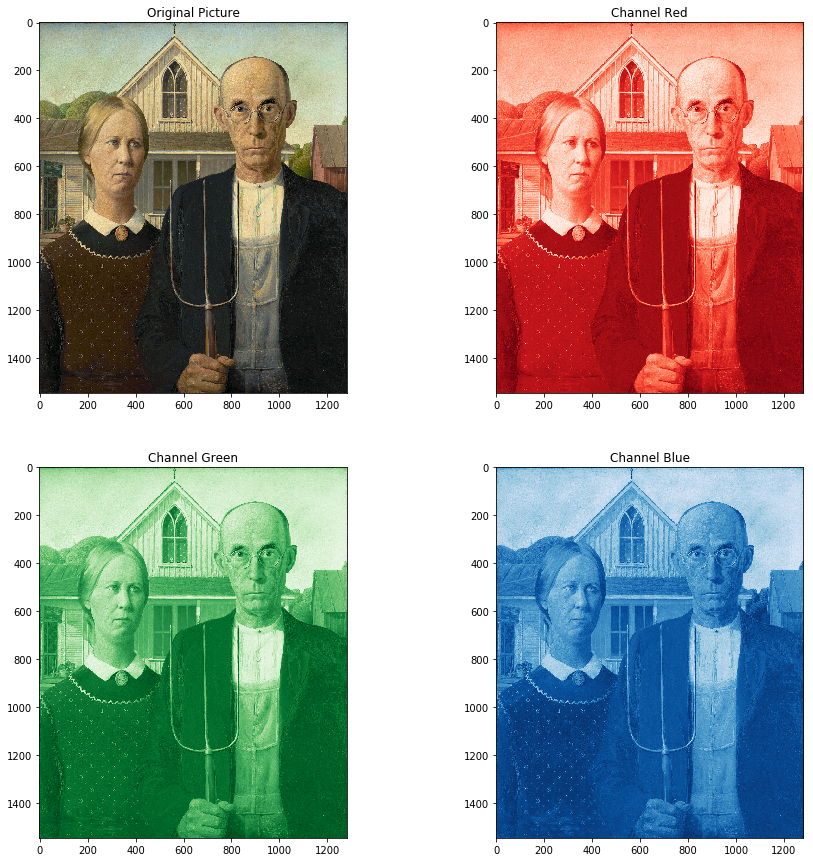

In [3]:
%matplotlib inline

def show_matrix(img_matrix):
    log('----')
    log(f'Image matrix of shape {img_matrix.shape}')
    log(f'min/avg/max on the channels: {np.min(img_matrix,axis=(0,1))}/{np.average(img_matrix,axis=(0,1))}/{np.max(img_matrix,axis=(0,1))}')
    # create a 2x2 plot area. Note: figsize is in inches, not pixels!
    fig, axes = pyplot.subplots(nrows=2, ncols=2, figsize=(15, 15))
    ax0, ax1, ax2, ax3 = axes.flatten()

    # display the image as whole and the 3 channels
    # imshow uses the 3 (or 4 for alpha) channels if the dimension is present, otherwise a colormap
    # some color maps are already defined ane named
    # the suffix _r is used to get the reverse scale, which represent in white the presence of the color
    ax0.imshow(img_matrix)
    ax0.set_title('Original Picture')
    for i, channel in enumerate(zip(axes.flatten(), [None, 'Reds_r','Greens_r','Blues_r'])):
        if channel[1] is None:
            continue
        channel[0].set_title('Channel ' + channel[1][:-3])
        channel[0].imshow(img_matrix[:,:,i-1], cmap=pyplot.get_cmap(channel[1]))

show_matrix(photo)

Let's extract the test and training datasets, in a format that libraries like. We don't care about a dev test because the execution will be one shot.

In [4]:
def extract_dataset(image, train_size=800, test_size=200, seed=0):
    np.random.seed(seed)
    coordinates_set = set()
    for i in range(train_size + test_size):
        x, y = np.random.randint(image.shape[0]), np.random.randint(image.shape[1])
        while (x,y) in coordinates_set:
            x, y = np.random.randint(image.shape[0]), np.random.randint(image.shape[1])
        coordinates_set.add((x,y))
    
    all_coordinates= [x for x in coordinates_set]
    X_train = np.array(all_coordinates[:train_size])
    X_test = np.array(all_coordinates[train_size:])
    # NOTE: use indexes to grab RGB values?
    # It requires broadcasting and the dimension is the trailing one, maybe transpose and use it?
    # Y_train = [image[x[0], x[1], :] for x in X_train]
    Y_train = np.zeros((X_train.shape[0], 3))
    for i,x in enumerate(X_train):
        Y_train[i] = image[x[0], x[1], :]
    Y_test = np.zeros((X_test.shape[0], 3))
    for i,x in enumerate(X_test):
        Y_test[i] = image[x[0], x[1], :]
    return X_train, Y_train, X_test, Y_test


log(extract_dataset(photo, train_size=2, test_size=10))
    
    

2018-02-24T18:32:29.476893 (array([[976, 755],
       [684, 559]]), array([[ 31.,  37.,  37.],
       [108., 106.,  91.]]), array([[1420,  314],
       [ 777,  115],
       [ 277,  599],
       [  87,  174],
       [1094,  600],
       [ 849,  537],
       [ 705,  551],
       [ 845,   72],
       [1216,  835],
       [ 763, 1033]]), array([[ 51.,  34.,  16.],
       [206., 186., 136.],
       [ 96.,  90.,  66.],
       [169., 182., 164.],
       [ 24.,  30.,  30.],
       [ 25.,  26.,  28.],
       [ 87.,  87.,  75.],
       [ 63.,  62.,  34.],
       [ 82.,  84.,  83.],
       [ 38.,  38.,  28.]]))


Let's start with a linear model. This assumes that the X,Y coordinates can be mapped to the three R,G,B values by a linear function. This is true only if our image is a gradient on each channel, so the result is expected to be very bad.

In [5]:
from sklearn import linear_model

X_train, Y_train, X_test, Y_test = extract_dataset(photo)
model = linear_model.LinearRegression(n_jobs=-1)
model.fit(X_train, Y_train)
log('the score on the test set is:', model.score(X_test, Y_test))
log('the score on the train set is:', model.score(X_train, Y_train))


2018-02-24T18:32:29.806556 the score on the test set is: (0.6310951309812427,)
2018-02-24T18:32:29.807527 the score on the train set is: (0.5682487879348017,)


/Users/jfarina/.virtualenvs/scientificnb/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Let's see the image predicted

2018-02-24T18:32:34.095749 ----
2018-02-24T18:32:34.095946 Image matrix of shape (1545, 1280, 3)
2018-02-24T18:32:34.207697 min/avg/max on the channels: [17  4  0]/[103.87266383  97.89419043  78.17946551]/[191 191 255]


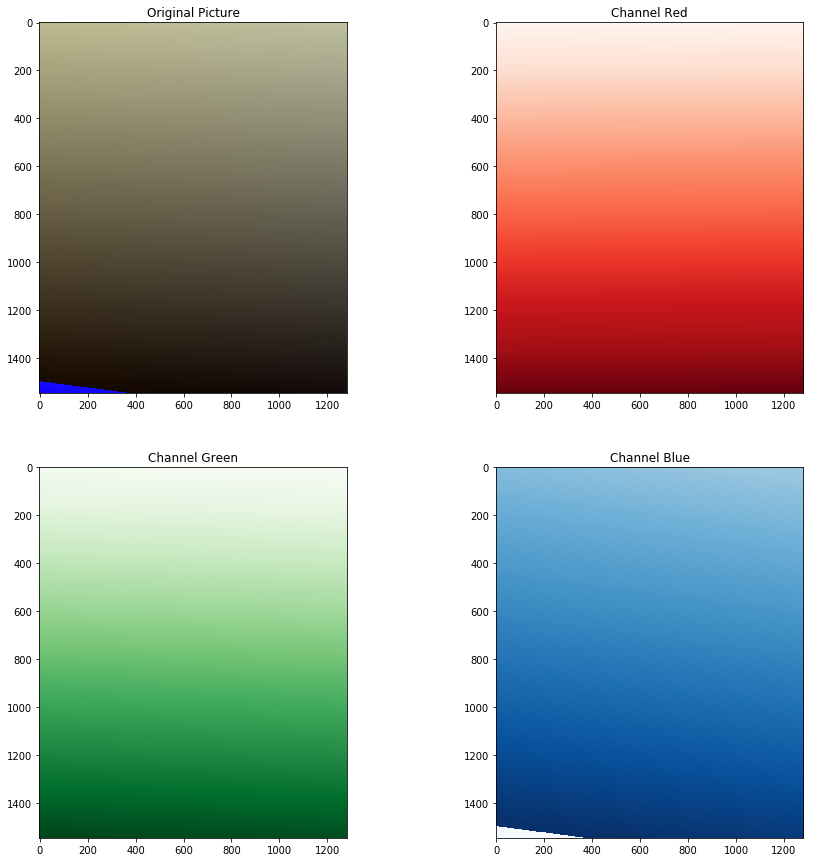

In [6]:
predict = np.zeros(photo.shape)

all_coordinates = np.array(list(itertools.product(np.arange(photo.shape[0]), np.arange(photo.shape[1]))))
all_results = model.predict(all_coordinates).astype(int)

for x in range(all_coordinates.shape[0]):
    predict[all_coordinates[x,0], all_coordinates[x,1]] = all_results[x]
show_matrix(predict.astype(np.uint8))

Not exactly similar to the original :) To be sure, let's see what happens if the image *is* a gradient. We expect in this case for the model to predict it quite well.

In [ ]:
photo_gradient = (pyplot.imread('../data/a_gradient.png') * 255).astype(np.uint8)
show_matrix(photo_gradient)
X_train_gradient, Y_train_gradient, X_test_gradient, Y_test_gradient = extract_dataset(photo_gradient, train_size=2000, test_size=200)
model_gradient = linear_model.LinearRegression(n_jobs=-1)
model_gradient.fit(X_train_gradient, Y_train_gradient)
log('the score on the test set is:', model_gradient.score(X_test_gradient, Y_test_gradient))
log('the score on the train set is:', model_gradient.score(X_train_gradient, Y_train_gradient))

predict = np.zeros(photo_gradient.shape)
all_coordinates = np.array(list(itertools.product(np.arange(photo_gradient.shape[0]), np.arange(photo_gradient.shape[1]))))
# let's see the prediction at some points. Note that the model gives prediction for every coordinate, it has no information about the boundaries
sample_points = [(0,0), (200, 200), (1280, 1280)]
for sp in sample_points:
    log(f'for the point {sp} the model predicts colors {model_gradient.predict([[sp[0], sp[1]]])}')
all_results = model_gradient.predict(all_coordinates)

for x in range(all_coordinates.shape[0]):
    predict[all_coordinates[x,0], all_coordinates[x,1]] = all_results[x]
    
    if (all_coordinates[x] == [2, 2]).all() or (all_coordinates[x] == [1279, 1279]).all():
        log(f'at coordinates {all_coordinates[x]} the result is {all_results[x]}, which become {all_results[x].astype(np.uint8)}')
        log(f'the value in the output matrix is {predict[all_coordinates[x][0], all_coordinates[x][1]]}')
show_matrix(predict.astype(np.uint8))

2018-02-24T18:35:24.492760 ----
2018-02-24T18:35:24.492985 Image matrix of shape (1280, 1280, 3)
2018-02-24T18:35:24.603266 min/avg/max on the channels: [111 176 178]/[164.5680188  198.74476929 187.00871094]/[211 221 203]


Interestingly, the original image had an artifact (best visible on the blue channel), that now has changed since it was not linear and the model couldn't model it, but the output was later subject to quantization.
A possibility to improve the result without abandoning the linear model is to add "fake" dimensions obtained as a non-linear transformation of existing ones. This way the model will use those as well for the input. This is known as *kernel trick* and scikitlearn provides a few functions to apply it, based on the statistical properties of input data. But for fun let's try with something simple to see what happens.

For each coordinate we can add the distances of that point to a grid of reference coordinates


In [ ]:
# 4 minutes with 300 pixel grid
# 32 minutes with 100 pixel grid
def enricher(coordinates):
    ref_coordinates = list(itertools.product(np.arange(0, photo.shape[0], 200), np.arange(0, photo.shape[1], 200)))
    return [coordinates[0],
            coordinates[1],
           ] + [np.sqrt((coordinates[0] - p[0]) ** 2 + (coordinates[1] - p[1]) ** 2) for p in ref_coordinates]



    
show_matrix(photo)

X_train, Y_train, X_test, Y_test = extract_dataset(photo, train_size=3000, test_size=500)

    
X_train_enriched = [enricher(c) for c in X_train]
X_test_enriched = [enricher(c) for c in X_test]


model_enriched = linear_model.LinearRegression(n_jobs=-1)
model_enriched.fit(X_train_enriched, Y_train)
log('the score on the test set is:', model_enriched.score(X_test_enriched, Y_test))
log('the score on the train set is:', model_enriched.score(X_train_enriched, Y_train))
predict = np.zeros(photo.shape)

log('Producing the enriched list of coordinates...')
all_coordinates = np.array(list(itertools.product(np.arange(photo.shape[0]), np.arange(photo.shape[1]))))
all_coordinates_enriched = np.array([enricher(c) for c in all_coordinates])

# this step is very slow. It could be parallelized using for example using concurrent.futures
log('Predicting values for all of them...')
all_results = model_enriched.predict(all_coordinates_enriched)

log('Creating the image matrix using the predictions...')
for x in range(all_coordinates.shape[0]):
    predict[all_coordinates[x][0], all_coordinates[x][1]] = all_results[x]

sample_points = [(0,0), (200, 200), (photo.shape[0] - 1 , photo.shape[1] -1)]
for sp in sample_points:
    log('---')
    log(f'for the point {sp} the predicted value is {predict[sp]} and the original value was {photo[sp]}, ')
    
show_matrix(predict.astype(np.uint8))


It worked, and in theory adding a growing number of independent non-linear functions and then increasing the number of sample points the model can be made arbitrarily accurate. A thing to notice is that this model is producing the *exact* set of parameters which reduces the quare error given the samples. It does not use any form of gradient descend.

The `enrich` function defined above applies a sort of RBF (Radial Basis Function): it assigns to each coordinate a set of extra parameters based on the distance of the point from some reference point. The distance is euclidean but other types of distances can be used as well.

We can compare the results with a proper implementation of SVM provided in Scikit-learn.

In [ ]:
from sklearn.svm import SVR


#show_matrix(photo)
kernel = 'rbf'
gamma=0.001

log(f'Defining untrained models with kernel type {kernel} and gamma value {gamma}')
svr_rbf_red   = SVR(kernel=kernel, gamma=gamma)
svr_rbf_green = SVR(kernel=kernel, gamma=gamma)
svr_rbf_blue  = SVR(kernel=kernel, gamma=gamma)

log('Generating test and train datasets...')
X_train, Y_train, X_test, Y_test = extract_dataset(photo, train_size=4000, test_size=0)

log('Fit the SVM for the 3 channels...')
svr_rbf_red.fit(X_train, Y_train[:, 0])
svr_rbf_green.fit(X_train, Y_train[:, 1])
svr_rbf_blue.fit(X_train, Y_train[:, 2])

log('Enumerate all coordinates...')
all_coordinates = np.array(list(itertools.product(np.arange(photo.shape[0]), np.arange(photo.shape[1]))))

log('Use the trained SVM models to predict all the pixels for RED...')
all_results_red = svr_rbf_red.predict(all_coordinates)
log('Use the trained SVM models to predict all the pixels for GREEN...')
all_results_green = svr_rbf_green.predict(all_coordinates)
log('Use the trained SVM models to predict all the pixels for BLUE...')
all_results_blue = svr_rbf_blue.predict(all_coordinates)

log('Reassemble an image from the predictions...')

predict = np.zeros(photo.shape)
for x in range(all_coordinates.shape[0]):
    predict[all_coordinates[x][0], all_coordinates[x][1]] = [all_results_red[x].astype(np.uint8), all_results_green[x].astype(np.uint8), all_results_blue[x].astype(np.uint8)]


show_matrix(predict.astype(np.uint8))

predict = predict - np.min(predict)
predict = predict * 255.0 / np.max(predict)
show_matrix(predict.astype(np.uint8))

In [ ]:
from sklearn import neighbors


#show_matrix(photo)


X_train, Y_train, X_test, Y_test = extract_dataset(photo, train_size=5000, test_size=0)
neighbors_model = neighbors.KNeighborsRegressor(n_neighbors=5, n_jobs=-1)
neighbors_model.fit(X_train, Y_train)


all_coordinates = np.array(list(itertools.product(np.arange(photo.shape[0]), np.arange(photo.shape[1]))))
all_results = neighbors_model.predict(all_coordinates)

predict = np.zeros(photo.shape)
for x in range(all_coordinates.shape[0]):
    predict[all_coordinates[x][0], all_coordinates[x][1]] = all_results[x].astype(np.uint8)

sample_points = [(0,0), (200, 200), (photo.shape[0] - 1 , photo.shape[1] -1)]
for sp in sample_points:
    log('---')
    log(f'for the point {sp} the model predicts colors {neighbors_model.predict([[sp[0], sp[1]]])}')
    log(f'the original value was {photo[sp]}, equal to {photo[sp[0], sp[1]]} and {predict[sp]}')
    
show_matrix(predict.astype(np.uint8))

In [ ]:
from sklearn import tree

X_train, Y_train, X_test, Y_test = extract_dataset(photo, train_size=100, test_size=0)
tree_model = tree.DecisionTreeRegressor()
tree_model.fit(X_train, Y_train)


all_coordinates = np.array(list(itertools.product(np.arange(photo.shape[0]), np.arange(photo.shape[1]))))
all_results = tree_model.predict(all_coordinates)

predict = np.zeros(photo.shape)
for x in range(all_coordinates.shape[0]):
    predict[all_coordinates[x][0], all_coordinates[x][1]] = all_results[x].astype(np.uint8)

sample_points = [(0,0), (200, 200), (photo.shape[0] - 1 , photo.shape[1] -1)]
for sp in sample_points:
    log('---')
    log(f'for the point {sp} the model predicts colors {tree_model.predict([[sp[0], sp[1]]])}')
    log(f'the original value was {photo[sp]}, equal to {photo[sp[0], sp[1]]} and {predict[sp]}')
    
show_matrix(predict.astype(np.uint8))